# Import Library

In [1]:
import os
from easydict import EasyDict
import pandas as pd

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
!pip install -U PyYAML
import yaml

     |████████████████████████████████| 645kB 14.8MB/s 
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
root_dir = '/content/drive/MyDrive/power_consumption/'
#root_dir = '/home/jngeun/Deep/power_consumption/'

In [24]:
with open(os.path.join(root_dir,'config.yaml'), "r") as f:
  C = EasyDict(yaml.load(f, yaml.FullLoader))

In [10]:
train=pd.read_csv(os.path.join(root_dir,C.train.csv),encoding='cp949')
test=pd.read_csv(os.path.join(root_dir,C.test.csv),encoding='cp949')
#train['비전기냉방설비운영'].fillna(0, inplace=True)
#train['태양광보유'].fillna(0, inplace=True)
submission=pd.read_csv(os.path.join(root_dir,C.result.csv),encoding='cp949')

# Define Class & Method

In [25]:
# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

In [26]:
def select_building(df,col):

    return df[df['num'] == col]

def train_test_split(df, ratio = C.dataset.ratio):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()

    for _, val in enumerate(df['num'].unique()):
        temp = select_building(df,val)
        boundary = int(ratio * temp.shape[0])
        
        data_train = pd.concat([data_train,temp.iloc[:boundary,:]])
        data_test = pd.concat(\
                              [data_test,temp.iloc[boundary- C.model.seq_length:, :]])

    return data_train, data_test

def test_dataset(df):
    
    df = df.drop(['num','date_time', '비전기냉방설비운영','태양광보유'],axis=1)
    #df.insert(0, '전력사용량(kWh)', np.nan)
    
    return df

In [27]:
class LSTMDataset(Dataset):
    def __init__(self, config, df, building):
      super().__init__()
      self.C = config
      self.df = select_building(df, building)

      self.X = self.drop_column(self.df)
      self.y = self.df['전력사용량(kWh)']
      

    def __len__(self):
          return len(self.df)

    def __getitem__(self,idx):
        X = self.X.iloc[idx:idx+ self.C.model.seq_length, :].to_numpy()
        y = np.expand_dims(self.y[idx + self.C.model.seq_length],axis=0)
      
        return X, y
    
    def drop_column(self,df):
        df = df.drop(self.C.dataset.drop,axis=1)

        return df


    def to_integer(self,dt_time):
        dt_time = t_time[0].split('-')
        
        return dt_time

    def build_dataset(self,time_series, seq_length = C.model.seq_length):
        dataX = []
        dataY = []
        for i in range(0, len(time_series) - seq_length):
            _x = time_series[i:i + seq_length, :]
            _y = time_series['전력사용량(kWh)'][i]
            print(_x, "->", _y)
            dataX.append(_x)
            dataY.append(_y)

        return np.array(dataX), np.array(dataY)

    def to_tensor(self,array):

        return torch.FloatTensor(array)

In [28]:
train_df, valid_df = train_test_split(train)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97920 entries, 0 to 121991
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num         97920 non-null  int64  
 1   date_time   97920 non-null  object 
 2   전력사용량(kWh)  97920 non-null  float64
 3   기온(°C)      97920 non-null  float64
 4   풍속(m/s)     97920 non-null  float64
 5   습도(%)       97920 non-null  float64
 6   강수량(mm)     97920 non-null  float64
 7   일조(hr)      97920 non-null  float64
 8   비전기냉방설비운영   97920 non-null  float64
 9   태양광보유       97920 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 8.2+ MB


In [30]:
ds_train = LSTMDataset(C,train_df,1)
dl_train = DataLoader(ds_train,
                      batch_size=C.dataset.batch_size
                      )

for X, y in dl_train:
  print(X.shape)
  print(y.shape)

KeyError: ignored

In [ ]:
class TestLSTMDataset(Dataset):
    def __init__(self, config, files):
    super.__init__()
    self.C = config
    self.files = files

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x

# Data Preprocessing

In [ ]:
#train.shape 122400 X 10
#60개의 건물 X 85일 24시간 =122400
train.tail(10)

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
122390,60,2020-08-24 14,4269.456,29.5,3.1,59.0,0.0,1.0,1.0,1.0
122391,60,2020-08-24 15,4323.888,29.5,3.4,58.0,0.0,1.0,1.0,1.0
122392,60,2020-08-24 16,4294.080,29.4,3.1,59.0,0.0,1.0,1.0,1.0
122393,60,2020-08-24 17,4212.432,28.7,2.9,60.0,0.0,1.0,1.0,1.0
122394,60,2020-08-24 18,4189.104,28.5,2.2,66.0,0.0,1.0,1.0,1.0
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0
122399,60,2020-08-24 23,3204.576,27.1,2.6,75.0,0.0,0.0,1.0,1.0


In [ ]:
test.head(10)

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,2020-08-25 05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,2020-08-25 06,26.1,1.3,83.0,0.0,0.0,NaN,NaN
7,1,2020-08-25 07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,2020-08-25 08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,2020-08-25 09,28.8,1.2,77.0,NaN,1.1,NaN,NaN


In [ ]:
building_num = 1

df = select_building(train,building_num)
X, y = train_dataset(df)
print(X.shape, y.shape)
X_train, y_train, X_test, y_test = train_test_split(X,y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

   기온(°C)  풍속(m/s)  습도(%)  강수량(mm)  일조(hr)
0    17.6      2.5   92.0      0.8     0.0
1    17.7      2.9   91.0      0.3     0.0
2    17.5      3.2   91.0      0.0     0.0
3    17.1      3.2   91.0      0.0     0.0
4    17.0      3.3   92.0      0.0     0.0
(2040, 5) (2040, 1)
(1632, 5) (1620, 1)
(420, 5) (408, 1)


In [ ]:
# scaling data
mm = MinMaxScaler()
ss = StandardScaler()

train_X_ss = ss.fit_transform(X_train)
trainY = mm.fit_transform(y_train) 

test_X_ss = ss.transform(X_test)
testY = mm.transform(y_test)

# make train-test dataset to input
trainX= build_dataset(train_X_ss, seq_length)
testX= build_dataset(test_X_ss, seq_length)

# convert to tensor
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

In [ ]:
print(f'trainX_tensor.shape : {trainX_tensor.shape} trainY_tensor.shape : {trainY_tensor.shape}')
print(f'testX_tensor.shape : {testX_tensor.shape} testY_tensor.shape : {testY_tensor.shape}')

trainX_tensor.shape : torch.Size([1620, 12, 5]) trainY_tensor.shape : torch.Size([1620, 1])
testX_tensor.shape : torch.Size([408, 12, 5]) testY_tensor.shape : torch.Size([408, 1])


# Model

In [ ]:
# loss & optimizer setting
net = Net(data_dim, hidden_dim, output_dim, 3)

criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# Train

In [ ]:
# start training
for i in range(iterations):

    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    print(i, loss.item())

0 0.8959444761276245
1 0.8253127932548523
2 0.7546467185020447
3 0.6763601899147034
4 0.582478940486908
5 0.46765804290771484
6 0.33169546723365784
7 0.18662142753601074
8 0.06579674035310745
9 0.015154428780078888
10 0.04783110320568085
11 0.09529424458742142
12 0.10854914039373398
13 0.09413409978151321
14 0.06809180229902267
15 0.04275438189506531
16 0.024762209504842758
17 0.0158507339656353
18 0.014601810835301876
19 0.018249720335006714
20 0.02398408204317093
21 0.029616080224514008
22 0.03376246616244316
23 0.03577122837305069
24 0.03555547818541527
25 0.03342198207974434
26 0.0299239382147789
27 0.025739187374711037
28 0.021565042436122894
29 0.018022526055574417
30 0.015568714588880539
31 0.014425557106733322
32 0.014542045071721077
33 0.01560959406197071
34 0.01714104227721691
35 0.018601305782794952
36 0.019551722332835197
37 0.019758163020014763
38 0.01922631449997425
39 0.018159765750169754
40 0.01686709001660347
41 0.01565774902701378
42 0.014760999009013176
43 0.01428544

# Test

In [ ]:
#결측치 채우기
X_test = test
X_test = X_test.interpolate(method='linear', limit_direction='forward', axis=0)
X_test.head(15)

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.800000,1.500000,74.000000,0.0,0.000000,NaN,NaN
1,1,2020-08-25 01,27.633333,1.366667,75.333333,0.0,0.000000,NaN,NaN
2,1,2020-08-25 02,27.466667,1.233333,76.666667,0.0,0.000000,NaN,NaN
3,1,2020-08-25 03,27.300000,1.100000,78.000000,0.0,0.000000,NaN,NaN
4,1,2020-08-25 04,26.900000,1.166667,79.666667,0.0,0.000000,NaN,NaN
5,1,2020-08-25 05,26.500000,1.233333,81.333333,0.0,0.000000,NaN,NaN
6,1,2020-08-25 06,26.100000,1.300000,83.000000,0.0,0.000000,NaN,NaN
7,1,2020-08-25 07,27.000000,1.266667,81.000000,0.0,0.366667,NaN,NaN
8,1,2020-08-25 08,27.900000,1.233333,79.000000,0.0,0.733333,NaN,NaN
9,1,2020-08-25 09,28.800000,1.200000,77.000000,0.0,1.100000,NaN,NaN


In [ ]:
input_data = select_building(X_test, 1)
input_data = test_dataset(input_data)
input_data.head(20)

,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)"
0,27.800000,1.500000,74.000000,0.0,0.000000
1,27.633333,1.366667,75.333333,0.0,0.000000
2,27.466667,1.233333,76.666667,0.0,0.000000
3,27.300000,1.100000,78.000000,0.0,0.000000
4,26.900000,1.166667,79.666667,0.0,0.000000
5,26.500000,1.233333,81.333333,0.0,0.000000
6,26.100000,1.300000,83.000000,0.0,0.000000
7,27.000000,1.266667,81.000000,0.0,0.366667
8,27.900000,1.233333,79.000000,0.0,0.733333
9,28.800000,1.200000,77.000000,0.0,1.100000


In [ ]:
input_data = ss.transform(input_data)
input_data = build_dataset(input_data,seq_length)
input_data = torch.FloatTensor(input_data)

tensor([[0.8323],
        [0.8402],
        [0.8493],
        [0.8599],
        [0.8726],
        [0.8921],
        [0.9125],
        [0.9310],
        [0.9288],
        [0.9172],
        [0.9045],
        [0.9115],
        [0.9225],
        [0.9344],
        [0.9345],
        [0.9314],
        [0.9212],
        [0.9124],
        [0.8968],
        [0.8775],
        [0.8454],
        [0.8104],
        [0.7909],
        [0.7958],
        [0.8158],
        [0.8401],
        [0.8712],
        [0.9018],
        [0.9265],
        [0.9333],
        [0.9323],
        [0.9292],
        [0.9267],
        [0.9221],
        [0.9081],
        [0.8706],
        [0.8269],
        [0.7942],
        [0.7718],
        [0.7572],
        [0.7492],
        [0.7443],
        [0.7403],
        [0.7365],
        [0.7354],
        [0.7387],
        [0.7483],
        [0.7577],
        [0.7670],
        [0.7784],
        [0.7914],
        [0.8071],
        [0.8228],
        [0.8342],
        [0.8354],
        [0

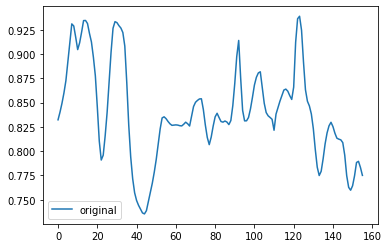

In [ ]:
pred = net(input_data)
print(pred)
plt.plot(pred.data.numpy())
plt.legend(['original', 'prediction'])
plt.show()

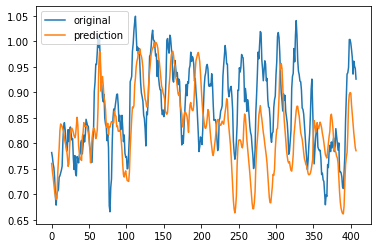

In [ ]:
plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()

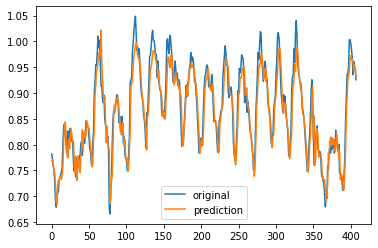

In [ ]:
plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()

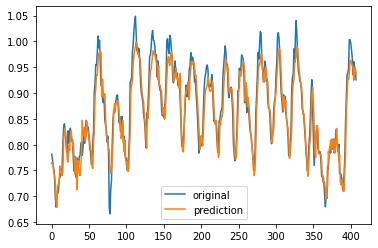

In [ ]:
plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()